1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy  # ensure scipy package is loaded
# explicitly import sparse and its linalg submodule to avoid attribute lookup issues
from scipy import sparse
from scipy.sparse import linalg as sparse_linalg
# ensure the attribute is available on scipy.sparse (some import systems don't auto-bind submodules)
setattr(scipy.sparse, 'linalg', sparse_linalg)

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"
df = pd.read_csv(file_path, usecols=usecols)

df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

4. Pipeline Specification & Hyperparameter Distributions

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# 4.1) safety: ensure feature lists exist (reconstruct if previous cell not run)
if 'cat_feats' not in globals() or 'num_feats' not in globals():
    cat_feats = [c for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay'] if c in df.columns]
    base_num = [
        'ImpProb_H','ImpProb_D','ImpProb_A',
        'ImpOver2.5','ImpUnder2.5','OddsSpread','Spread×Form',
        'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
        'RefBias','H2H_Last','HomePosPrev','AwayPosPrev',
        'Home_HS_3','Home_HST_3','Home_HF_3','Home_HC_3','Home_HY_3','Home_HR_3',
        'Away_AS_3','Away_AST_3','Away_AF_3','Away_AC_3','Away_AY_3','Away_AR_3'
    ]
    num_feats = [c for c in base_num if c in df.columns]

# 4.2) preprocessing: OHE for categoricals (sparse), StandardScaler for numerics (dense-friendly for MLP)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=True))
])
num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', StandardScaler(with_mean=True, with_std=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_feats),
        ('num', num_pipe, num_feats)
    ],
    sparse_threshold=1.0  # output may be sparse because of OHE; we densify before Keras
)

# 4.3) Keras MLP with BatchNorm + L2 + Dropout (robust on small tabular data)
def make_mlp(input_dim: int, hidden1: int = 96, hidden2: int = 48,
             dropout: float = 0.35, l2_reg: float = 1e-3, lr: float = 5e-4) -> Model:
    tf.keras.utils.set_random_seed(42)
    inp = layers.Input(shape=(input_dim,), name='x')

    x = layers.Dense(hidden1, use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(hidden2, use_bias=False,
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 4.4) class-weight utility (balanced + slight Draw boost)
def compute_class_weights(y_int: np.ndarray, draw_boost: float = 1.3) -> dict:
    # expects labels mapped to {0,1,2} (we map below)
    if y_int.size == 0:
        return {0:1.0, 1:1.0, 2:1.0}
    vals, counts = np.unique(y_int, return_counts=True)
    total = counts.sum()
    weights = {int(v): float(total / (len(vals) * c)) for v, c in zip(vals, counts)}
    for k in [0,1,2]:
        weights.setdefault(k, 1.0)
    # bump Draw (class index 1) to improve recall
    weights[1] = weights.get(1, 1.0) * draw_boost
    return weights

# 4.5) label mapping (-1,0,1) ↔ (0,1,2) for Keras sparse targets
label2idx = {-1: 0, 0: 1, 1: 2}
idx2label = {v: k for k, v in label2idx.items()}

# 4.6) tiny config set for automatic selection per round (fast)
MLP_CONFIGS = [
    # (hidden1, hidden2, dropout, l2,   lr,   batch)
    (96,   48,   0.35,    1e-3, 5e-4,   64),
    (64,   32,   0.40,    1e-3, 7e-4,  128),
    (128,  64,   0.30,    3e-4, 1e-3,   64),
]

# 4.7) callbacks: EarlyStopping + ReduceLROnPlateau
EARLY_STOP = tf.keras.callbacks.EarlyStopping(
    patience=8, monitor='val_accuracy', restore_best_weights=True
)
REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5, verbose=0
)
MAX_EPOCHS = 80

5. Round-by-Round Training & Prediction with Tuning

In [5]:
from scipy import sparse

# 5.1) containers
preds, actuals, rounds, match_indices = [], [], [], []

# 5.2) warm-up (first 5 rounds) – fit preprocessor and quick warm start
WARMUP_ROUNDS  = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

warm_mask_all = df.index < WARMUP_MATCHES
val_mask_warm = (df['Round'] == WARMUP_ROUNDS) & warm_mask_all
if val_mask_warm.sum() >= 10:
    train_mask_warm = warm_mask_all & (~val_mask_warm)
else:
    warm_sorted = df.loc[warm_mask_all].sort_values(['Round','MatchIndex']).index
    split = int(len(warm_sorted) * 0.9)
    val_mask_warm = df.index.isin(warm_sorted[split:])
    train_mask_warm = df.index.isin(warm_sorted[:split])

# Fit preprocessor on warm-train only (leakage-safe)
X_tr_w = preprocessor.fit_transform(df.loc[train_mask_warm, cat_feats + num_feats])
X_va_w = preprocessor.transform(df.loc[val_mask_warm,  cat_feats + num_feats])

# Densify for Keras
X_tr_w = X_tr_w.toarray() if sparse.issparse(X_tr_w) else np.asarray(X_tr_w)
X_va_w = X_va_w.toarray() if sparse.issparse(X_va_w) else np.asarray(X_va_w)

y_tr_w = df.loc[train_mask_warm, 'Outcome'].map(label2idx).to_numpy()
y_va_w = df.loc[val_mask_warm,  'Outcome'].map(label2idx).to_numpy()

# Build small warm-up model (use first config)
input_dim = X_tr_w.shape[1]
h1, h2, dr, l2r, lr, bs = MLP_CONFIGS[0]
mlp_w = make_mlp(input_dim, h1, h2, dr, l2r, lr)
cw_w = compute_class_weights(y_tr_w, draw_boost=1.3)
_ = mlp_w.fit(
    X_tr_w, y_tr_w,
    validation_data=(X_va_w, y_va_w),
    epochs=MAX_EPOCHS, batch_size=bs, verbose=0,
    class_weight=cw_w, callbacks=[EARLY_STOP, REDUCE_LR]
)

# 5.3) predict from round 6 onward (always 10 matches/round)
max_round = int(df['Round'].max())
best_model = None  # will hold the last round's best model

for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # Build test slice and enforce exactly 10 matches
    round_df = df.loc[test_mask, :].sort_values(['Round','MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
        test_mask = df.index.isin(round_df.index)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    # Validation = last full round r-1 if available, else last 10% of train
    val_mask = (df['Round'] == (r - 1)) & train_mask
    if val_mask.sum() < 10:
        tr_sorted = df.loc[train_mask].sort_values(['Round','MatchIndex']).index
        split = int(len(tr_sorted) * 0.9)
        val_mask = df.index.isin(tr_sorted[split:])
        train_mask = df.index.isin(tr_sorted[:split])
    else:
        train_mask = train_mask & (~val_mask)

    # Transform with preprocessor (fit on train only each round!)
    X_train = preprocessor.fit_transform(df.loc[train_mask, cat_feats + num_feats])
    X_val   = preprocessor.transform(df.loc[val_mask,  cat_feats + num_feats])
    X_test  = preprocessor.transform(df.loc[test_mask, cat_feats + num_feats])

    # Dense arrays for Keras
    X_train = X_train.toarray() if sparse.issparse(X_train) else np.asarray(X_train)
    X_val   = X_val.toarray()   if sparse.issparse(X_val)   else np.asarray(X_val)
    X_test  = X_test.toarray()  if sparse.issparse(X_test)  else np.asarray(X_test)

    y_train = df.loc[train_mask, 'Outcome'].map(label2idx).to_numpy()
    y_val   = df.loc[val_mask,  'Outcome'].map(label2idx).to_numpy()
    y_test  = df.loc[test_mask, 'Outcome'].to_numpy()  # keep original labels for reporting

    # Tiny automatic config selection (3 configs) using val accuracy
    best_val, best_model, best_cfg = -1.0, None, None
    cw = compute_class_weights(y_train, draw_boost=1.3)

    for (h1, h2, dr, l2r, lr, bs) in MLP_CONFIGS:
        model = make_mlp(input_dim=X_train.shape[1], hidden1=h1, hidden2=h2,
                         dropout=dr, l2_reg=l2r, lr=lr)
        _ = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=MAX_EPOCHS, batch_size=bs, verbose=0,
            class_weight=cw, callbacks=[EARLY_STOP, REDUCE_LR]
        )
        # Evaluate on validation
        val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_acc > best_val:
            best_val = val_acc
            best_model = model
            best_cfg = (h1, h2, dr, l2r, lr, bs)

    # Predict exactly 10 matches with the best model
    y_prob = best_model.predict(X_test, verbose=0)
    y_pred_idx = y_prob.argmax(axis=1)
    y_pred = np.vectorize(idx2label.get)(y_pred_idx)

    # Collect results
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_pred))            # always 10
    match_indices.extend(round_df['MatchIndex'].tolist())

    # Per-round accuracy (accuracy only) + log best config
    acc = accuracy_score(y_test, y_pred)
    h1, h2, dr, l2r, lr, bs = best_cfg
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f} | "
          f"cfg: h=({h1},{h2}) drop={dr:.2f} l2={l2r:.0e} lr={lr:.0e} bs={bs}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# 5.4) expose final trained model and last training round
final_model = best_model
last_train_round = max_round - 1

Round 6: 10 matches | accuracy = 0.400 | cfg: h=(96,48) drop=0.35 l2=1e-03 lr=5e-04 bs=64
Round 7: 10 matches | accuracy = 0.100 | cfg: h=(96,48) drop=0.35 l2=1e-03 lr=5e-04 bs=64
Round 8: 10 matches | accuracy = 0.300 | cfg: h=(128,64) drop=0.30 l2=3e-04 lr=1e-03 bs=64
Round 9: 10 matches | accuracy = 0.400 | cfg: h=(96,48) drop=0.35 l2=1e-03 lr=5e-04 bs=64
Round 10: 10 matches | accuracy = 0.700 | cfg: h=(96,48) drop=0.35 l2=1e-03 lr=5e-04 bs=64
Round 11: 10 matches | accuracy = 0.200 | cfg: h=(96,48) drop=0.35 l2=1e-03 lr=5e-04 bs=64
Round 12: 10 matches | accuracy = 0.100 | cfg: h=(64,32) drop=0.40 l2=1e-03 lr=7e-04 bs=128
Round 13: 10 matches | accuracy = 0.400 | cfg: h=(128,64) drop=0.30 l2=3e-04 lr=1e-03 bs=64
Round 14: 10 matches | accuracy = 0.500 | cfg: h=(128,64) drop=0.30 l2=3e-04 lr=1e-03 bs=64
Round 15: 10 matches | accuracy = 0.200 | cfg: h=(96,48) drop=0.35 l2=1e-03 lr=5e-04 bs=64
Round 16: 10 matches | accuracy = 0.100 | cfg: h=(64,32) drop=0.40 l2=1e-03 lr=7e-04 bs=12

6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\mlp_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Save final trained pipeline
dump(model, r"D:\python\premier league predictor\mlp_pl_pipeline.joblib")
print("Final MLP pipeline saved.")

Results written to D:\python\premier league predictor\mlp_predictions_vs_actuals.xlsx
Final MLP pipeline saved.


7. Results & Visualization

Overall accuracy (rounds 6–38): 0.345


C:\Users\markf\AppData\Local\Temp\ipykernel_15952\3664346691.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['Actual'], g['Pred']))


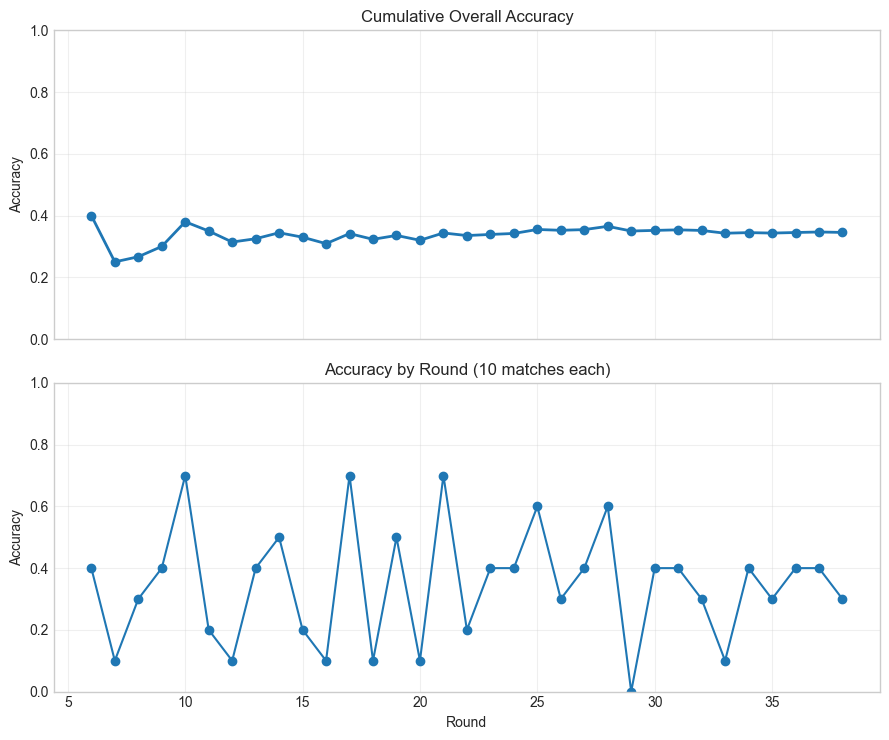

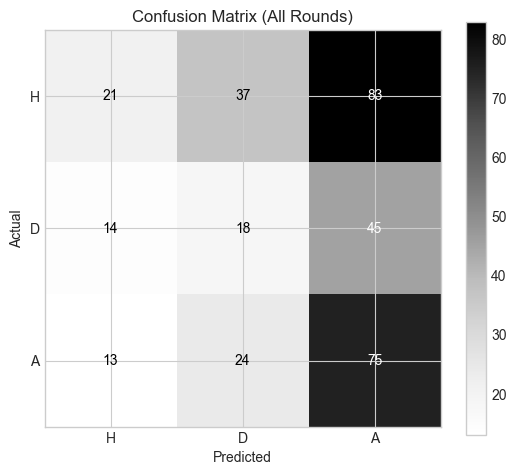

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# --- 7.1 Overall accuracy (text) ---
overall_acc = accuracy_score(actuals, preds)
print(f"Overall accuracy (rounds {WARMUP_ROUNDS + 1}–{max_round}): {overall_acc:.3f}")

# --- 7.2 Build results frame in round order ---
res_df = pd.DataFrame({
    'Round': rounds,
    'Pred':  preds,
    'Actual': actuals
})
res_df = res_df.sort_values('Round')

# --- 7.3 Accuracy by round + cumulative overall accuracy curve ---
# per-round accuracy
acc_by_round = (
    res_df.groupby('Round')
          .apply(lambda g: accuracy_score(g['Actual'], g['Pred']))
          .reset_index(name='Accuracy')
          .sort_values('Round')
)

# cumulative (overall) accuracy across rounds (weighted by matches, not simple mean)
# count correct predictions per row, then aggregate by round
res_df['Correct'] = (res_df['Pred'] == res_df['Actual']).astype(int)
correct_by_round = res_df.groupby('Round')['Correct'].sum().reset_index(name='CorrectCount')
matches_by_round = res_df.groupby('Round').size().reset_index(name='N')

cum = correct_by_round.merge(matches_by_round, on='Round').sort_values('Round')
cum['CumCorrect'] = cum['CorrectCount'].cumsum()
cum['CumTotal']   = cum['N'].cumsum()
cum['CumAcc']     = cum['CumCorrect'] / cum['CumTotal']

# --- 7.4 Plots: cumulative accuracy (top) + per-round accuracy (bottom) ---
fig, axes = plt.subplots(2, 1, figsize=(9, 7.5), sharex=True)

# (a) cumulative accuracy curve
axes[0].plot(cum['Round'], cum['CumAcc'], marker='o', linewidth=2)
axes[0].set_title('Cumulative Overall Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(True, alpha=0.3)

# (b) per-round accuracy curve
axes[1].plot(acc_by_round['Round'], acc_by_round['Accuracy'], marker='o')
axes[1].set_title('Accuracy by Round (10 matches each)')
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 7.5 Confusion matrix (H, D, A) — heatmap with counts ---
label_order = [1, 0, -1]  # keep the usual order: Home, Draw, Away
label_to_str = {1:'H', 0:'D', -1:'A'}
cm = confusion_matrix(actuals, preds, labels=label_order)

plt.figure(figsize=(5.6, 4.8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (All Rounds)')
plt.colorbar()
tick_marks = np.arange(len(label_order))
plt.xticks(tick_marks, [label_to_str[x] for x in label_order])
plt.yticks(tick_marks, [label_to_str[x] for x in label_order])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()


8. Gradio Interface

In [8]:
import gradio as gr

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Last historical rows
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble feature dict
    data = {}
    # 2a) Odds-derived features
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    # 2c) Interaction
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    # 2e) Head-to-head last result
    pair = (
        ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) |
        ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    )
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    # 2g) Rolling match-stats
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) Predict
    Xnew    = pd.DataFrame([data])
    probs   = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day")
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (LightGBM)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with historical averages; "
        "other features come from past matches."
    )
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.
